In [1]:
!pip install pyLDAvis
!pip install mallet
!pip install gensim

In [2]:
!pip install --upgrade numpy
!pip install --upgrade seaborn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
import mallet
import os
import re
import nltk

In [4]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from pprint import pprint

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [7]:
df=pd.read_csv('/content/drive/MyDrive/Skripsi/twitter_clean.csv')
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet_lemmatized,text_clean
0,"['mathlievetradingsignaltime075924design', 'cl...",mathlievetradingsignaltime075924design closing...
1,"['chatgpt', 'cause', 'website', 'scrap', 'stop...",chatgpt cause website scrap stop get updated p...
2,"['one', 'way', 'education', 'foundation', 'cou...",one way education foundation could stop pay ma...
3,"['african', 'union', 'commission', 'fall', 'vi...",african union commission fall victim cybercrim...
4,['chatgpt'],chatgpt


In [8]:
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_row', 100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing

In [9]:
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1038, 2)

In [11]:
#Remove duplicates
df = df.drop_duplicates()
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(984, 2)

In [13]:
#Remove URL from tweet text
df['Text'] = df['text_clean'].apply(lambda x: re.sub(r'http\S+', '',x))
#Remove mention (@user)
df['Text'] = df['Text'].apply(lambda x: re.sub(r'@\S+', '',x))
#All lowercases
df['Text'] = df['Text'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
#Remove Punctuation
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-d1a9f1bd1167>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['text_clean'].apply(lambda x: re.sub(r'http\S+', '',x))
<ipython-input-13-d1a9f1bd1167>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [14]:
#Replace 'chat gpt' with 'chatgpt'
df['Text'] = df['Text'].apply(lambda x: re.sub(r'chat gpt', 'chatgpt', x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-14-3d8935df515d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].apply(lambda x: re.sub(r'chat gpt', 'chatgpt', x))


In [15]:
#remove stopwords, short tokens, and accents
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)
#simple_preprocess: Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
df['Token'] = df['Text'].apply(lambda x: [word for word in simple_preprocess(x) if word not in stopwords])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-15-95bc6b6e4f4f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Token'] = df['Text'].apply(lambda x: [word for word in simple_preprocess(x) if word not in stopwords])


In [16]:
df_test = df[0:1000].copy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
#Build the bigram and trigrams
bigram = Phrases(df['Token'], min_count=10, threshold=10)
# #bigram[df['Token']] will apply the bigram object to each row of the df['Token'] column
df['Bigram'] = bigram[df['Token']]
bigram_mod = gensim.models.phrases.Phraser(bigram)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-17-ef5d663140aa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bigram'] = bigram[df['Token']]


In [18]:
trigram = Phrases(df['Bigram'], min_count=10, threshold=10)
df['Trigram'] = trigram[df['Bigram']]
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-18-03b30d8e4500>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Trigram'] = trigram[df['Bigram']]


In [19]:
df[df['Trigram']!=df['Bigram']][0:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet_lemmatized,text_clean,Text,Token,Bigram,Trigram
8,"['wring', 'child', 'heart', 'face', 'like', 'd...",wring child heart face like death reach sittin...,wring child heart face like death reach sittin...,"[wring, child, heart, face, like, death, reach...","[wring, child, heart, face, like, death, reach...","[wring, child, heart, face, like, death, reach..."
16,"['however', 'take', 'high', 'hand', 'try', 'fi...",however take high hand try find pretext quarre...,however take high hand try find pretext quarre...,"[however, take, high, hand, try, find, pretext...","[however, take, high, hand, try, find, pretext...","[however, take, high, hand, try, find, pretext..."
36,"['pfdyz9jf', 'connection', 'lead', 'excite', '...",pfdyz9jf connection lead excite butter appropr...,pfdyz9jf connection lead excite butter appropr...,"[pfdyz, jf, connection, lead, excite, butter, ...","[pfdyz, jf, connection, lead, excite, butter, ...","[pfdyz, jf, connection, lead, excite, butter, ..."
62,"['93649', 'uneasy', 'venture', 'go', 'house', ...",93649 uneasy venture go house go one friend ch...,93649 uneasy venture go house go one friend ch...,"[uneasy, venture, go, house, go, one, friend, ...","[uneasy, venture, go, house, go, one, friend, ...","[uneasy, venture, go, house, go, one, friend, ..."
75,"['webuvo', 'contribution', 'hire', 'practical'...",webuvo contribution hire practical put moral c...,webuvo contribution hire practical put moral c...,"[webuvo, contribution, hire, practical, put, m...","[webuvo, contribution, hire, practical, put, m...","[webuvo, contribution, hire, practical, put, m..."


In [20]:
# Get the bigram and trigram phrases
biphrase = bigram.export_phrases()
triphrase = trigram.export_phrases()
print(f'Bi:{len(biphrase)}, Tri:{len(triphrase)}')

Bi:31, Tri:19


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
biphrase, triphrase

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


({'chatgpt账号_飞机号': 168.72941176470587,
  '飞机号_推特账号': 194.68778280542986,
  'chatgpt账号_小火箭': 86.92121212121212,
  '小火箭_推特账号': 100.2937062937063,
  'ai_agi': 24.226351351351354,
  'friend_download': 213.42261904761904,
  'download_free': 149.39583333333331,
  'free_audio': 140.6078431372549,
  'audio_review': 131.81985294117646,
  'review_copy': 82.99768518518518,
  'copy_amp': 35.41234567901235,
  'amp_leave': 50.32280701754386,
  'leave_review': 117.94407894736841,
  'gemini_amp': 59.75833333333333,
  'amp_llama': 56.24313725490196,
  'llama_journey': 222.0123839009288,
  'journey_ai': 17.00094831673779,
  'agi_asi': 298.79166666666663,
  'asi_amp': 63.742222222222225,
  'amp_singularity': 63.742222222222225,
  'singularity_transformative': 318.7111111111111,
  'transformative_innovation': 177.06172839506172,
  'innovation_book': 132.79629629629628,
  'book_series': 224.09375,
  'series_amazon': 263.6397058823529,
  'amazon_audible': 281.2156862745098,
  'audible_redeem': 318.711111111

In [22]:
# Get the bigram and trigram vocabularies
bigram_vocab = bigram.vocab
trigram_vocab = trigram.vocab

# Sort the bigram and trigram vocabularies by frequency in descending order
sorted_bigram_vocab = sorted(biphrase.items(), key=lambda x: x[1], reverse=True)
sorted_trigram_vocab = sorted(triphrase.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most common bigrams and trigrams
print("Top 10 most common bigrams:")
for phrase, freq in sorted_bigram_vocab[:10]:
    print("{}: {}".format(phrase, freq))

print("\nTop 10 most common trigrams:")
for phrase, freq in sorted_trigram_vocab[:10]:
    print("{}: {}".format(phrase, freq))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 10 most common bigrams:
singularity_transformative: 318.7111111111111
audible_redeem: 318.7111111111111
redeem_onetime: 318.7111111111111
agi_asi: 298.79166666666663
amazon_audible: 281.2156862745098
series_amazon: 263.6397058823529
book_series: 224.09375
llama_journey: 222.0123839009288
friend_download: 213.42261904761904
飞机号_推特账号: 194.68778280542986

Top 10 most common trigrams:
series_amazon: 35832.5
gemini_amp_llama_journey: 17916.25
friend_download: 11944.166666666668
llama_journey: 8958.125
friend_download_free_audio: 5972.083333333334
chatgpt账号_小火箭: 3583.25
innovation_book_series_amazon: 2986.041666666667
free_audio: 2388.833333333333
gemini_amp: 2388.833333333333
innovation_book: 1194.4166666666665


In [23]:
# bi-gram and tri-gram implementation
import time
start_time = time.time()
df['Token'] = df['Token'].apply(lambda x:bigram_mod[x])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken1: {total_time:.2f} seconds")

start_time = time.time()
df['Token']= df['Token'].apply(lambda x:trigram_mod[bigram_mod[x]])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken2: {total_time:.2f} seconds")

Total time taken1: 0.01 seconds
Total time taken2: 0.02 seconds


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-23-53b5f5ea00db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Token'] = df['Token'].apply(lambda x:bigram_mod[x])
<ipython-input-23-53b5f5ea00db>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [24]:
#Lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')


#define a function to map POS tags from treebank tag into wordnet tags
wnl = WordNetLemmatizer()
def get_wordnet(pos):
    if pos.startswith('N'):
        return wordnet.NOUN
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN     #default to noun if no match


# Define a function to tag and lemmatize a text string
def lemmatizer(text):
    pos_tags = pos_tag(text)
    text = [wnl.lemmatize(word, pos = get_wordnet(pos)) for word, pos in pos_tags]
    return text

start_time = time.time()

df['Lemmatized'] = df['Token'].apply(lambda x: lemmatizer(x))

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Total time taken: 1.80 seconds


<ipython-input-24-6cf63f076149>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lemmatized'] = df['Token'].apply(lambda x: lemmatizer(x))


In [25]:
# remove stopwords and short tokens again after lemmatization
df['Text_new'] = df['Lemmatized'].apply(lambda x: ' '.join(x))
df['Tokens'] = df['Text_new'].apply(lambda x: [word for word in simple_preprocess(x, deacc=True, min_len=3, max_len=50) if word not in stopwords])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-25-d671fbec11ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text_new'] = df['Lemmatized'].apply(lambda x: ' '.join(x))
<ipython-input-25-d671fbec11ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [26]:
df_1 = df.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
#df = df.drop(columns =['Text', 'Token', 'Lemmatized', 'Text_new'])
df.to_csv('Twitter_english_clean.csv',index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create the Dictionary and Corpus

In [28]:
df = pd.read_csv('/content/Twitter_english_clean.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
import ast
# # convert the string of words in the 'Tweet_lemmatized' column to a list for each row in the dataframe
df['Tokens'] = df['Tokens'].apply(lambda x: ast.literal_eval(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
dictionary = Dictionary(df['Tokens'])
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 3870


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
corpus = [dictionary.doc2bow(doc) for doc in df['Tokens']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
#create a dictionary to show the word and frequency in the corpus
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else:
            dict_corpus[dictionary[idx]] = freq
df_dict = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# Top 10 high-frequency words
df_dict.sort_values('frequency', ascending = False).head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,frequency
chatgpt,903
use,173
get,92
like,91
ask,76
make,65
write,64
prompt,59
know,54
time,49


In [34]:
# Filter extreme words
dictionary.filter_extremes(no_below=10, no_above=0.5)  #words occur in less than 10 tweets, or more than 50% of tweets
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 193


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Recreate the corpus for LDA model
corpus = [dictionary.doc2bow(doc) for doc in df['Tokens']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Re-check the top words
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else:
            dict_corpus[dictionary[idx]] = freq
df_dict_new = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])
df_dict_new.sort_values('frequency', ascending = False).head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,frequency
use,173
get,92
like,91
ask,76
make,65
write,64
prompt,59
know,54
time,49
one,46


In [37]:
# Generate a test corpus
corpus_test = [dictionary.doc2bow(doc) for doc in df['Tokens'][0:1000]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
len(corpus),len(dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(984, 193)

## LDA Model Implementation

In [39]:
import time
import logging
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
num_topics = 3
passes = 2
total_iteration = num_topics*passes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
start_time =time.time()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# train the LdaModel
lda_model = LdaModel(corpus=corpus_test, id2word=dictionary, num_topics=num_topics, passes=passes)

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken: 0.99 seconds


In [42]:
# Display topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('use', 0.046597745),
   ('get', 0.026237575),
   ('like', 0.024725435),
   ('work', 0.023930453),
   ('one', 0.01931532),
   ('give', 0.01761475),
   ('good', 0.015804876),
   ('dont', 0.015313896),
   ('dalle', 0.015077751),
   ('gpt', 0.015039565)]),
 (1,
  [('use', 0.070790954),
   ('write', 0.027188318),
   ('make', 0.02578263),
   ('say', 0.02287058),
   ('ask', 0.02261253),
   ('like', 0.0219547),
   ('know', 0.01750724),
   ('technology', 0.01655007),
   ('think', 0.015664063),
   ('something', 0.013665948)]),
 (2,
  [('get', 0.028729416),
   ('prompt', 0.024292098),
   ('new', 0.023119813),
   ('ask', 0.02106647),
   ('well', 0.01987158),
   ('would', 0.01947045),
   ('like', 0.018457552),
   ('take', 0.015871355),
   ('write', 0.015238453),
   ('time', 0.014510926)])]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
#Compute Coherence Score
cm = CoherenceModel(model=lda_model, corpus = corpus, coherence='c_v', texts=df['Tokens'])
coherence = cm.get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
print(f'Coherence score: {coherence}')

Coherence score: 0.3155782953333249


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# To increase the speed, use a multicore Lda model
from gensim.models.ldamulticore import LdaMulticore
start_time =time.time()
#Train the LdaMulticore model
lda_model_m = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, workers=2)

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken: 2.03 seconds


In [46]:
pprint(lda_model_m.show_topics(formatted=False))

[(0,
  [('use', 0.05755049),
   ('get', 0.032425735),
   ('ask', 0.032151222),
   ('new', 0.023719145),
   ('make', 0.022168087),
   ('like', 0.021529917),
   ('good', 0.019343564),
   ('chatgpt账号_飞机号_推特账号', 0.014319792),
   ('help', 0.013705823),
   ('time', 0.01311329)]),
 (1,
  [('write', 0.035143416),
   ('prompt', 0.025678134),
   ('use', 0.024625394),
   ('even', 0.020324726),
   ('get', 0.02024526),
   ('gpt', 0.018884776),
   ('openai', 0.018750982),
   ('know', 0.017703768),
   ('ask', 0.01629511),
   ('would', 0.015342302)]),
 (2,
  [('use', 0.03755833),
   ('like', 0.028887102),
   ('one', 0.021800302),
   ('make', 0.021296455),
   ('amp', 0.018305015),
   ('work', 0.017590009),
   ('tool', 0.016976217),
   ('think', 0.015706081),
   ('google', 0.015123676),
   ('know', 0.0146882385)])]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
cm_m = CoherenceModel(model=lda_model_m, corpus = corpus, coherence='c_v', texts=df['Tokens'])
coherence_m = cm_m.get_coherence()
print(f'Coherence score: {coherence_m}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence score: 0.341613037157196


### Optimal Topic Numbers

In [48]:
def model_coherence_generator(corpus, dictionary, data, start_topic, end_topic, step, passes, workers):
    models = []
    coherence_scores = []
    for num in tqdm(range(start_topic, end_topic+1, step)):
        ldamodel = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num, passes=passes, workers=workers)
        cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
        score = cv_coherence_model.get_coherence()

        coherence_scores.append(score)
        models.append(ldamodel)
    return models, coherence_scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
#Get the coherence scores by varing the number of topics
lda_models, coherence_scores = model_coherence_generator(corpus, dictionary, df['Tokens'], start_topic=2, end_topic=40, step=2, passes=10, workers=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


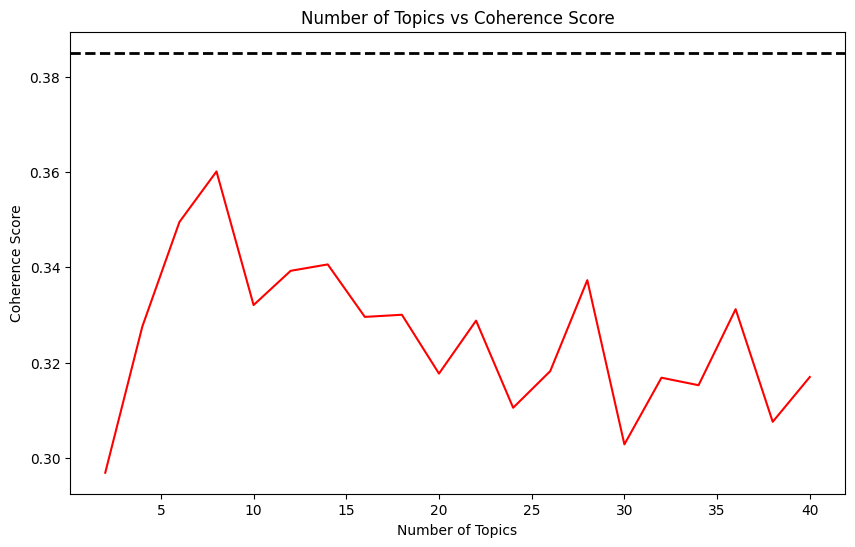

In [50]:
#Plot the number of topics vs coherence score
x_ax = range(2, 41, 2)
y_ax = coherence_scores
plt.figure(figsize=(10, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.385, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Number of Topics vs Coherence Score')
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')
plt.show()

In [51]:
coherence_scores[1],coherence_scores[3]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.3275710398161845, 0.36009266503578646)

In [52]:
#save the lda_model with 10 topics
lda_1 = lda_models[1]
lda_3=lda_models[3]
lda_1.save('lda_1')
lda_3.save('lda_3')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
import pickle
#save the model
pickle.dump(lda_1, open('ldamodel_t1.pkl', 'wb'))
pickle.dump(lda_3, open('ldaModel_t3.pkl', 'wb'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
#load model
lda_1 = LdaModel.load('/content/lda_1')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
vis_data_1 = pyLDAvis.gensim.prepare(lda_1, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
vis_data_3 = pyLDAvis.gensim.prepare(lda_3, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
pyLDAvis.display(vis_data_1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
pyLDAvis.display(vis_data_3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Optimal Iteration

In [84]:
#Iterate LdaMulticore model over varing passes
def model_coherence_generator_2(corpus, dictionary, data, passes):
    ldamodel = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=4, passes=passes, workers=20, random_state=42)
    cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
    score = cv_coherence_model.get_coherence()
    return ldamodel, score

models = []
coherence_scores = []
for passes in tqdm([1, 5, 10, 20, 40, 60, 80, 100]):
    model, score = model_coherence_generator_2(corpus, dictionary, df['Tokens'], passes)
    models.append(model)
    coherence_scores.append(score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 8/8 [02:08<00:00, 16.01s/it]


In [85]:
coherence_scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.34914927862907563,
 0.31602983065144985,
 0.29594373398656487,
 0.30855462534620004,
 0.3136626665973252,
 0.29904413478072034,
 0.3084329040008991,
 0.32486476943693365]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


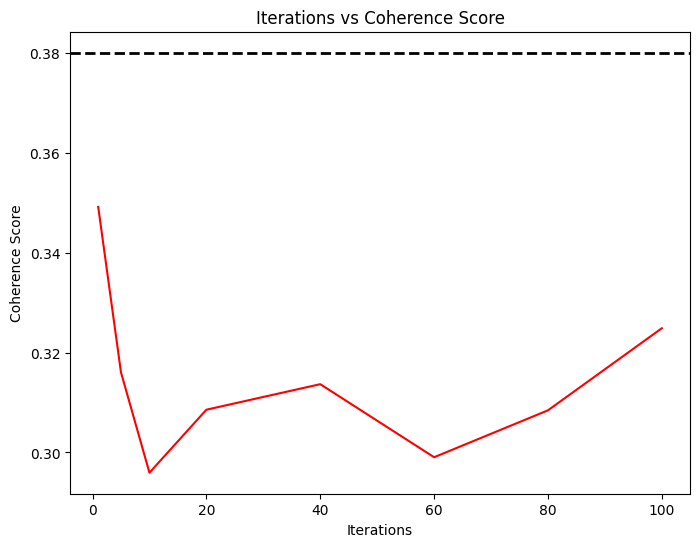

In [86]:
#Plot the iteration times vs coherence score
x_ax = [1, 5, 10, 20, 40, 60, 80, 100]
y_ax = coherence_scores
plt.figure(figsize=(8, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y= 0.380, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Iterations vs Coherence Score')
xl = plt.xlabel('Iterations')
yl = plt.ylabel('Coherence Score')
plt.show()

In [87]:
lda_t4_p1 = models[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
lda_4_1 = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=4, passes=1, workers=20)
cv_coherence_model = CoherenceModel(model=lda_4_1, corpus = corpus, coherence='c_v', texts=df["Tokens"])
score = cv_coherence_model.get_coherence()
print(score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2969546254432863


In [89]:
lda_4_1.save('lda_4_p1')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
import pickle

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
lda_4_1 = LdaModel.load('/content/lda_4_p1')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
pprint(lda_4_1.show_topics())

[(0,
  '0.075*"use" + 0.033*"make" + 0.027*"get" + 0.023*"would" + '
  '0.023*"chatgpt账号_飞机号_推特账号" + 0.020*"ask" + 0.018*"know" + 0.017*"like" + '
  '0.017*"think" + 0.015*"time"'),
 (1,
  '0.024*"get" + 0.023*"say" + 0.019*"google" + 0.017*"prompt" + 0.017*"time" '
  '+ 0.017*"new" + 0.016*"good" + 0.015*"help" + 0.014*"like" + '
  '0.014*"market"'),
 (2,
  '0.046*"use" + 0.031*"prompt" + 0.022*"like" + 0.022*"write" + 0.019*"image" '
  '+ 0.018*"dalle" + 0.016*"new" + 0.013*"ask" + 0.013*"take" + '
  '0.012*"innovation_book_series_amazon"'),
 (3,
  '0.033*"get" + 0.030*"one" + 0.029*"like" + 0.028*"ask" + 0.022*"write" + '
  '0.018*"good" + 0.018*"know" + 0.016*"use" + 0.015*"gpt" + 0.015*"well"')]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
pprint(lda_1.show_topics())

[(0,
  '0.067*"use" + 0.032*"new" + 0.031*"write" + 0.025*"like" + 0.022*"ask" + '
  '0.019*"people" + 0.019*"question" + 0.016*"work" + 0.016*"answer" + '
  '0.015*"know"'),
 (1,
  '0.041*"prompt" + 0.040*"get" + 0.037*"use" + 0.032*"say" + '
  '0.029*"chatgpt账号_飞机号_推特账号" + 0.021*"really" + 0.020*"try" + 0.020*"dalle" + '
  '0.020*"amp" + 0.020*"dont"'),
 (2,
  '0.050*"make" + 0.029*"great" + 0.029*"use" + 0.028*"chatgpt账号_小火箭_推特账号" + '
  '0.027*"review" + 0.026*"find" + 0.025*"build" + 0.023*"ai_agi_asi_amp" + '
  '0.023*"innovation_book_series_amazon" + 0.023*"review_copy_amp_leave"'),
 (3,
  '0.034*"like" + 0.032*"ask" + 0.029*"time" + 0.028*"one" + 0.028*"get" + '
  '0.027*"technology" + 0.024*"would" + 0.022*"tech" + 0.022*"well" + '
  '0.021*"openai"')]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
vis_data_4_1 = pyLDAvis.gensim.prepare(lda_4_1, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
pyLDAvis.display(vis_data_4_1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Identification of Topics

In [96]:
#get the topic distribution for each tweets
topic_dist = [lda_4_1[doc] for doc in corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
#get the dominant topic and the score
dominant_topic = [max(topic, key=lambda x:x[1])[0] for topic in topic_dist]
scores =[max(topic, key=lambda x:x[1])[1] for topic in topic_dist]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
#Create a dataframe to show dominant topic for each tweet
df_topic = df[['Text','Token']].copy()
df_topic['Dominant_Topic'] = [topic+1 for topic in dominant_topic]
df_topic['Contribution%'] = [round(score*100,2) for score in scores]
df_topic.head(50)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text,Token,Dominant_Topic,Contribution%
0,mathlievetradingsignaltime075924design closing point accord thecryptocurrency ai btc etherum bnb orc20 bch xrp usdt shib link dydx chatgpt,"['design', 'closing', 'point', 'accord', 'ai', 'btc', 'etherum', 'bnb', 'orc', 'bch', 'xrp', 'usdt', 'shib', 'link', 'dydx', 'chatgpt']",3,60.46
1,chatgpt cause website scrap stop get updated plan train model still also think far early ai company get sue oblivion ip theft,"['chatgpt', 'cause', 'website', 'scrap', 'stop', 'get', 'updated', 'plan', 'train', 'model', 'still', 'also', 'think', 'far', 'early', 'ai', 'company', 'get', 'sue', 'oblivion', 'ip', 'theft']",1,91.16
2,one way education foundation could stop pay many people endless englishmajoring chatgpt start pay people system work systemsmatter,"['one', 'way', 'education', 'foundation', 'could', 'stop', 'pay', 'many', 'people', 'endless', 'englishmajoring', 'chatgpt', 'start', 'pay', 'people', 'system', 'work', 'systemsmatter']",4,91.76
3,african union commission fall victim cybercrime use deep fake impersonate head moussa faki incident highlight need strong cybersecurity measure worldwide cybersecurity deepfakes africanunioncommission,"['african', 'union', 'commission', 'fall', 'victim', 'cybercrime', 'use', 'deep', 'fake', 'impersonate', 'head', 'moussa', 'faki', 'incident', 'highlight', 'need', 'strong', 'cybersecurity', 'measure', 'worldwide', 'cybersecurity', 'deepfakes']",1,74.41
4,chatgpt,['chatgpt'],1,25.00
5,premium account available prem canva pro netflix nf hbo go share yt youtube grammarly gram ph mura spotify quillbot turnitin disney plus amazon prime chatgpt vivamax spotify spoti ph mura wts lfb lf prem wtb lf bns jungkook twice seventeen 2kshwkzj,"['premium', 'account', 'available', 'prem', 'canva', 'pro', 'netflix', 'nf', 'hbo', 'go', 'share', 'yt', 'youtube', 'grammarly', 'gram', 'ph', 'mura', 'spotify', 'quillbot', 'turnitin', 'disney', 'plus', 'amazon', 'prime', 'chatgpt', 'vivamax', 'spotify', 'spoti', 'ph', 'mura', 'wts', 'lfb', 'lf', 'prem', 'wtb', 'lf', 'bns', 'jungkook', 'twice', 'seventeen', 'kshwkzj']",4,80.97
6,chatgpt education folder insane,"['chatgpt', 'education', 'folder', 'insane']",1,25.00
7,drink enough red bull simulate effect drug limitless chatgpt burn 8 environment lifespan come new slur nonbinary people,"['drink', 'enough', 'red', 'bull', 'simulate', 'effect', 'drug', 'limitless', 'chatgpt', 'burn', 'environment', 'lifespan', 'come', 'new', 'slur', 'nonbinary', 'people']",3,83.90
8,wring child heart face like death reach sittingroom parent chatgpt账号 飞机号 推特账号 推特号 linkedin账号 46441,"['wring', 'child', 'heart', 'face', 'like', 'death', 'reach', 'sittingroom', 'parent', 'chatgpt账号_飞机号_推特账号', '推特号', 'linkedin账号']",1,73.57
9,chatgpt disruption stack overflow lay 28 percent staff ai,"['chatgpt', 'disruption', 'stack', 'overflow', 'lay', 'percent', 'staff', 'ai']",1,25.00


In [99]:
# Count and percentage of tweets for each topic
df_topic_summary = df_topic.groupby('Dominant_Topic').agg({'Text':'count'}).copy().reset_index()
df_topic_summary.rename(columns={'Text':'Total_text'}, inplace=True)
df_topic_summary['Percentage%'] = round(df_topic_summary['Total_text']/df_topic.shape[0]*100,2)
df_topic_summary=df_topic_summary.sort_values('Total_text', ascending=False).reset_index(drop=True)
df_topic_summary

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Total_text,Percentage%
0,1,385,39.13
1,4,253,25.71
2,3,186,18.90
3,2,160,16.26


In [100]:
#To sort the highly relevant tweets for each topics and interprete the topic names.
df_topic[df_topic['Dominant_Topic']==2].sort_values('Contribution%', ascending=False)[0:100]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text,Token,Dominant_Topic,Contribution%
883,translate plain english help chatgpt 1 uniswaps late version let trader super specific want trade 2 paper find best trading strategy new system 3 author create way liquidity,"['translate', 'plain', 'english', 'help', 'chatgpt', 'uniswaps', 'late', 'version', 'let', 'trader', 'super', 'specific', 'want', 'trade', 'paper', 'find', 'best', 'trading', 'strategy', 'new', 'system', 'author', 'create', 'way', 'liquidity']",2,94.14
458,could talk chatgpt create private account talk void think nice sometimes get word actually friend listen way dont worry exhaust real people,"['could', 'talk', 'chatgpt', 'create', 'private', 'account', 'talk', 'void', 'think', 'nice', 'sometimes', 'get', 'word', 'actually', 'friend', 'listen', 'way', 'dont', 'worry', 'exhaust', 'real', 'people']",2,93.88
675,copy script chatgpt fuck 8 year old could write something convince already know world side long bother try make scenario anyone two braincells buy,"['copy', 'script', 'chatgpt', 'fuck', 'year', 'old', 'could', 'write', 'something', 'convince', 'already', 'know', 'world', 'side', 'long', 'bother', 'try', 'make', 'scenario', 'anyone', 'two', 'braincells', 'buy']",2,93.73
283,know feel kind bad choose chatgpt google think 1 chatgpt release ad support version 2 google bard eventually rival potentially replace chatgpt kind query 3 google may offer adfree version bard 20m,"['know', 'feel', 'kind', 'bad', 'choose', 'chatgpt', 'google', 'think', 'chatgpt', 'release', 'ad', 'support', 'version', 'google', 'bard', 'eventually', 'rival', 'potentially', 'replace', 'chatgpt', 'kind', 'query', 'google', 'may', 'offer', 'adfree', 'version', 'bard']",2,93.47
46,tried get chatgpt actually something interesting art tool tend towards cheesy amp literal threw stanford encyclopedia philosophys definition art amp make go round selfcritique still meh good,"['tried', 'get', 'chatgpt', 'actually', 'something', 'interesting', 'art', 'tool', 'tend', 'towards', 'cheesy', 'amp', 'literal', 'threw', 'stanford', 'encyclopedia', 'philosophys', 'definition', 'art', 'amp', 'make', 'go', 'round', 'selfcritique', 'still', 'meh', 'good']",2,93.22
907,certify prompt engineer prompt engineering elicit desire response principle effective prompt engineering openai api system message multilingual amp multicultural context chatgpt bard claude chatgpt playground enroll today,"['certify', 'prompt', 'engineer', 'prompt', 'engineering', 'elicit', 'desire', 'response', 'principle', 'effective', 'prompt', 'engineering', 'openai', 'api', 'system', 'message', 'multilingual', 'amp', 'multicultural', 'context', 'chatgpt', 'bard', 'claude', 'chatgpt', 'playground', 'enroll', 'today']",2,92.07
507,tried prompt original post chatgpt dalle 3 tip specific gpt follow exact prompt find would alter,"['tried', 'prompt', 'original', 'post', 'chatgpt', 'dalle', 'tip', 'specific', 'gpt', 'follow', 'exact', 'prompt', 'find', 'would', 'alter']",2,91.99
846,chatgpt infer personal detail anonymous text new research show popular llm able accurately guess user race occupation location feed seemingly trivial chat via,"['chatgpt', 'infer', 'personal', 'detail', 'anonymous', 'text', 'new', 'research', 'show', 'popular', 'llm', 'able', 'accurately', 'guess', 'user', 'race', 'occupation', 'location', 'feed', 'seemingly', 'trivial', 'chat', 'via']",2,91.76
527,cut noise amp become market obvious option niche market research chatgpt handle heavy lift 20 min keep reading coachesagency owner think market research timewasting process,"['cut', 'noise', 'amp', 'become', 'market', 'obvious', 'option', 'niche', 'market', 'research', 'chatgpt', 'handle', 'heavy', 'lift', 'min', 'keep', 'reading', 'coachesagency', 'owner', 'think', 'market', 'research', 'timewasting', 'process']",2,91.42
260,personalize chatgpt content dont settle generic ai customize prompt match brand voice engage unique content embrace multimodal future leverage visuals audio ai via dalle demoed inside chatgpt possibilit

In [101]:
#Summarize the topic names based on each topics' top terms and highly-relevant tweets
names = {1:"T1 Information Technology",
        2:"T2 Education and Foundations",
        3:"T3 Experiment AI",
        4:"T4 Random Ask and Conversations"
        }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
df_topic['Topic_Name'] = df_topic['Dominant_Topic'].map(names)
df_topic.to_csv('Twitter_topics.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
#creat a topic dataframe
topics = [[(term, round(weight,3)) for term, weight in lda_4_1.show_topic(n,topn=20)] for n in range(0,lda_4_1.num_topics)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
pd.set_option('display.max_colwidth', None)
topic_df = pd.DataFrame({'Topic_Name':names.values(),
                         'Topic_Terms':[','.join([term for term, weight in topic]) for topic in topics]},
                        index = ['Topic ' + str(n) for n in range(1,lda_4_1.num_topics+1)])
# apply style to align content to the left
topic_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Name,Topic_Terms
Topic 1,T1 Information Technology,"use,make,get,would,chatgpt账号_飞机号_推特账号,ask,know,like,think,time,work,give,need,try,openai,technology,great,read,problem,see"
Topic 2,T2 Education and Foundations,"get,say,google,prompt,time,new,good,help,like,market,via,way,write,amp,research,call,want,something,tech,find"
Topic 3,T3 Experiment AI,"use,prompt,like,write,image,dalle,new,ask,take,innovation_book_series_amazon,review_copy_amp_leave,singularity_transformative,onetime_use,audible_redeem,gemini_amp_llama_journey,code_promo_code,friend_download_free_audio,ai_agi_asi_amp,review,time"
Topic 4,T4 Random Ask and Conversations,"get,one,like,ask,write,good,know,use,gpt,well,amp,work,dont,let,many,generate,experience,think,could,code"


In [105]:
df_temp = df_topic_summary.sort_values('Dominant_Topic')
topic_df['Text_count'] = df_temp['Total_text'].values
topic_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Name,Topic_Terms,Text_count
Topic 1,T1 Information Technology,"use,make,get,would,chatgpt账号_飞机号_推特账号,ask,know,like,think,time,work,give,need,try,openai,technology,great,read,problem,see",385
Topic 2,T2 Education and Foundations,"get,say,google,prompt,time,new,good,help,like,market,via,way,write,amp,research,call,want,something,tech,find",160
Topic 3,T3 Experiment AI,"use,prompt,like,write,image,dalle,new,ask,take,innovation_book_series_amazon,review_copy_amp_leave,singularity_transformative,onetime_use,audible_redeem,gemini_amp_llama_journey,code_promo_code,friend_download_free_audio,ai_agi_asi_amp,review,time",186
Topic 4,T4 Random Ask and Conversations,"get,one,like,ask,write,good,know,use,gpt,well,amp,work,dont,let,many,generate,experience,think,could,code",253


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-106-51e6f7928abb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=topic_df['Topic_Name'], x=topic_df['Text_count'], order=sort_name, palette='PuBuGn')


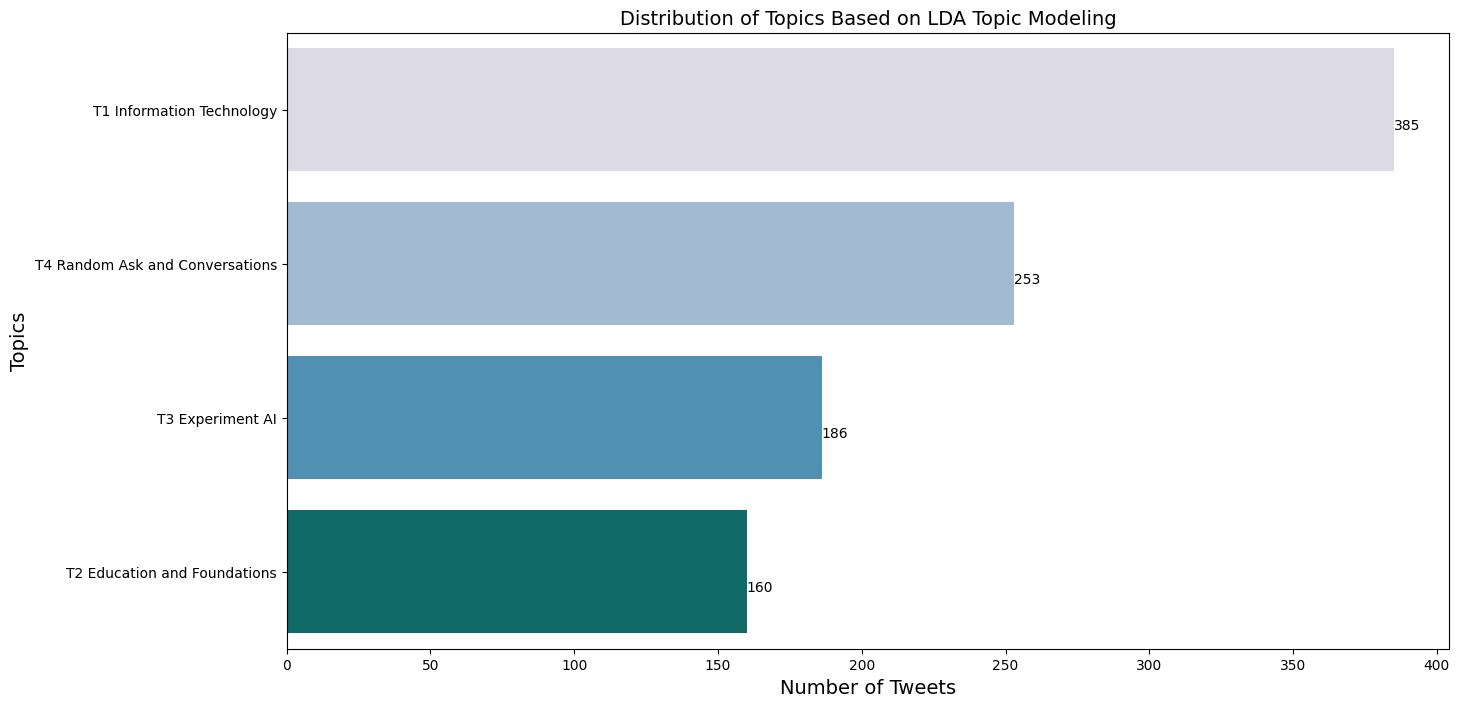

In [106]:
#plot a bar chart to show the number of tweets for each topic
sort_name = topic_df.sort_values('Text_count',ascending=False)['Topic_Name'].to_list()
fig,ax = plt.subplots(1,1,figsize=(15,8))
ax = sns.barplot(y=topic_df['Topic_Name'], x=topic_df['Text_count'], order=sort_name, palette='PuBuGn')
for i in ax.patches:
    ax.annotate(int(i.get_width()), (i.get_width(), i.get_y()+0.5), va='center')
ax.set_ylabel('Topics', size=14)
ax.set_xlabel('Number of Tweets', size=14)
ax.set_title('Distribution of Topics Based on LDA Topic Modeling', size=14)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-107-2648c8d815c4>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wc.generate(topic_df['Topic_Terms'][i])


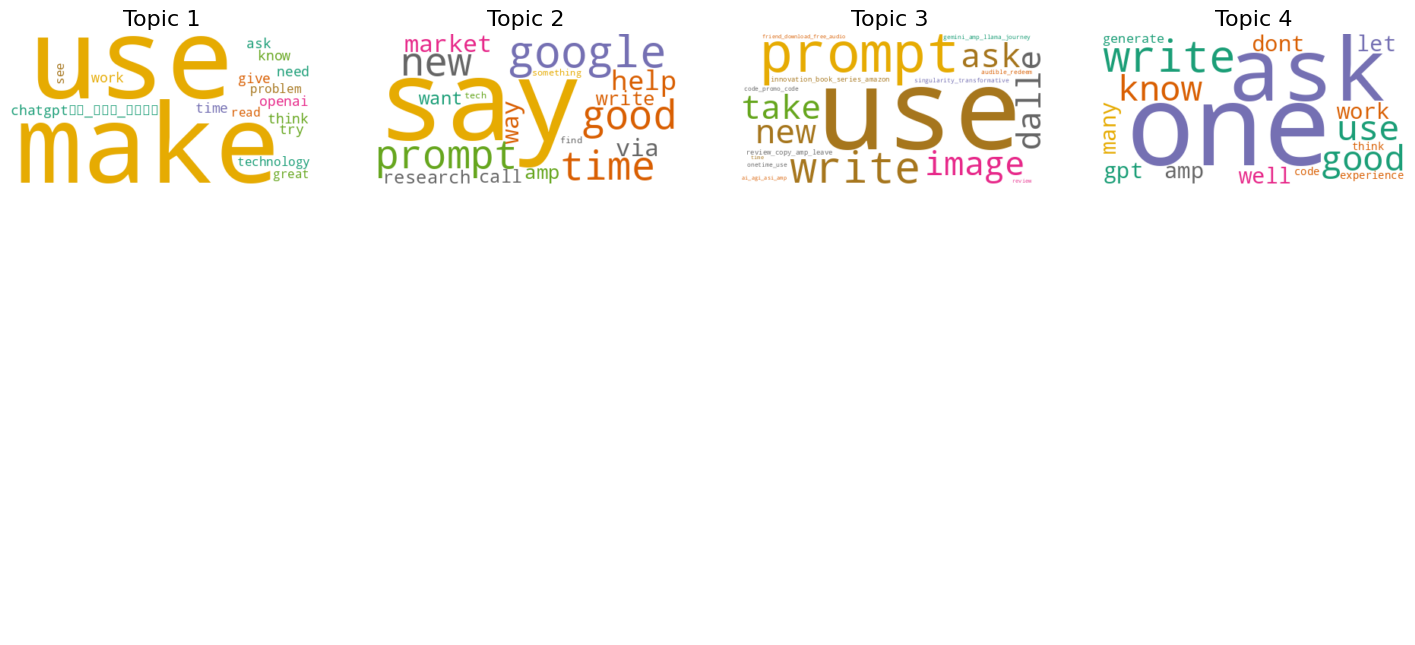

In [107]:
# word cloud
from wordcloud import WordCloud
wc = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=42)
fig, axs = plt.subplots(3,4, figsize=(18,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    if i<4:
        wc.generate(topic_df['Topic_Terms'][i])
        plt.subplot(3,4,i+1)
        plt.imshow(wc, interpolation="bilinear")
        plt.title(topic_df.index[i], size=16)
    plt.axis('off')

plt.show()


### Pembobotan Kata TF-IDF

In [113]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi objek TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Terapkan metode fit_transform pada data teks
tfidf_matrix = tfidf_vectorizer.fit_transform(df_topic['Text'])

# Simpan hasil pembobotan TF-IDF dalam file pickle
with open('tfidf_matrix.pickle', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

# Simpan objek TfidfVectorizer juga jika diperlukan
with open('tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
